In [26]:
!pip install nltk

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
 
import tensorflow as tf
 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
train = pd.read_excel('Data_Train.xlsx')
test = pd.read_excel('Data_Test.xlsx')
submission = pd.read_excel('Sample_submission.xlsx')

In [30]:
train.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


In [31]:
train.STORY[5]

"BEIJING: Chinese tech giant Huawei has announced plans to release a next-generation smartphone based on its own technology instead of US components, stepping up efforts to compete directly with Western industry leaders.\n\n\nThursday's announcement comes as Huawei Technologies Ltd., the world's biggest maker of network gear for phone companies, combats US warnings the company might be a security risk."

In [32]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
 
def preprocess(text, stem=False):
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)
 
train.STORY = train.STORY.apply(lambda x: preprocess(x))
test.STORY = test.STORY.apply(lambda x: preprocess(x))

In [33]:
train.STORY[5]

"BEIJING: Chinese tech giant Huawei announced plans release next-generation smartphone based technology instead US components, stepping efforts compete directly Western industry leaders. Thursday's announcement comes Huawei Technologies Ltd., world's biggest maker network gear phone companies, combats US warnings company might security risk."

Text(0.5, 1.0, 'Data Distribution')

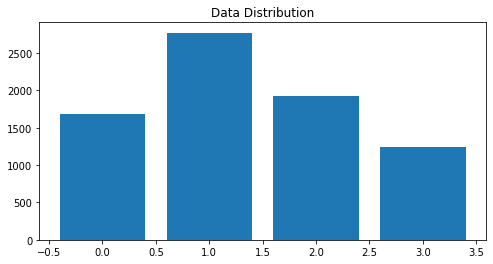

In [34]:
val_count = train.SECTION.value_counts()
 
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Data Distribution")

In [35]:
# avg sentence size
sum = 0
for i in range(len(train.STORY)):
  sum+=len(train.STORY[i].split())
avg = sum//len(train.STORY)
avg

68

In [36]:
vocab_size = 20000
embedding_dim = 12
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [37]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train.STORY)
word_index = tokenizer.word_index

In [38]:
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'also': 4,
 'bjp': 9,
 'congress': 10,
 'india': 5,
 'it': 7,
 'new': 6,
 'said': 3,
 'the': 2,
 'year': 8}

In [39]:
train_sequences = tokenizer.texts_to_sequences(train.STORY)
test_sequences = tokenizer.texts_to_sequences(test.STORY)

In [40]:
train.STORY[5]

"BEIJING: Chinese tech giant Huawei announced plans release next-generation smartphone based technology instead US components, stepping efforts compete directly Western industry leaders. Thursday's announcement comes Huawei Technologies Ltd., world's biggest maker network gear phone companies, combats US warnings company might security risk."

In [41]:
print(train_sequences[5])

[2311, 203, 473, 986, 214, 151, 409, 357, 131, 1066, 34, 78, 106, 603, 24, 2804, 6462, 1246, 2942, 1428, 1774, 290, 204, 6882, 1182, 114, 214, 587, 156, 1274, 330, 653, 527, 4076, 70, 81, 1, 24, 8022, 36, 282, 122, 598]


In [42]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [43]:
train_padded[5]

array([2311,  203,  473,  986,  214,  151,  409,  357,  131, 1066,   34,
         78,  106,  603,   24, 2804, 6462, 1246, 2942, 1428, 1774,  290,
        204, 6882, 1182,  114,  214,  587,  156, 1274,  330,  653,  527,
       4076,   70,   81,    1,   24, 8022,   36,  282,  122,  598,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

In [44]:
from keras.utils import to_categorical
one_hot_label = to_categorical(train.SECTION)

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 12)          240000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 24)          2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 24)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 24)          3552      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 24)                3552      
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

In [46]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
num_epochs = 35
history = model.fit(train_padded, one_hot_label,epochs=num_epochs, verbose=1, batch_size=32)

Epoch 1/35
239/239 [==============================] - 46s 192ms/step - loss: 0.8897 - accuracy: 0.6200
Epoch 2/35
239/239 [==============================] - 46s 193ms/step - loss: 0.2342 - accuracy: 0.9417
Epoch 3/35
239/239 [==============================] - 46s 193ms/step - loss: 0.1069 - accuracy: 0.9731
Epoch 4/35
239/239 [==============================] - 46s 192ms/step - loss: 0.0496 - accuracy: 0.9882
Epoch 5/35
239/239 [==============================] - 46s 192ms/step - loss: 0.0400 - accuracy: 0.9907
Epoch 6/35
239/239 [==============================] - 46s 192ms/step - loss: 0.0237 - accuracy: 0.9949
Epoch 7/35
239/239 [==============================] - 46s 192ms/step - loss: 0.0396 - accuracy: 0.9912
Epoch 8/35
239/239 [==============================] - 46s 192ms/step - loss: 0.0429 - accuracy: 0.9890
Epoch 9/35
239/239 [==============================] - 46s 192ms/step - loss: 0.0164 - accuracy: 0.9957
Epoch 10/35
239/239 [==============================] - 46s 192ms/step - l

In [ ]:
ypred = model.predict_classes(test_padded)

In [ ]:
ypred

In [ ]:
submission.SECTION = ypred

submission.to_excel('Submission.xlsx', index=False)